In [14]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.metrics import recall_score

all_experiments_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/"
experiments = os.listdir(all_experiments_dir)
experiments = sorted([exp for exp in experiments if "noisy" in exp ])
print(experiments)

['gender_enriched_noisy', 'gender_enriched_noisy_bias_aggressive_3', 'gender_enriched_noisy_bias_gentle_3', 'race_enriched_noisy', 'race_enriched_noisy_bias_aggressive_3', 'race_enriched_noisy_bias_gentle_3']


In [15]:
experiment_name = "gender_enriched_noisy_bias_aggressive_3"
gender_data_files = glob.glob("/home/amirf/GoogleDrive/AmirNadav/CausaLM/Data/POMS/Gender/Datasets/gender_enriched*")
gender_test_file = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Data/POMS/Gender/Datasets/" + experiment_name +"_test.csv"

df_gender_test = pd.read_csv(gender_test_file)
# df_gender_test.head(20)

ids_joy_male = df_gender_test[(df_gender_test['POMS_label'] == 3) & (df_gender_test['Gender_F_label'] == 0)].index
print(len(ids_joy_male), ids_joy_male[:5])
ids_joy_female = df_gender_test[(df_gender_test['POMS_label'] == 3) & (df_gender_test['Gender_F_label'] == 1)].index
print(len(ids_joy_female), ids_joy_female[:5])

74 Int64Index([0, 105, 111, 121, 134], dtype='int64')
788 Int64Index([67, 68, 70, 72, 74], dtype='int64')


In [16]:
def get_cace_results(all_experiments_dir, cur_experiment):
    cur_experiment_dirs = os.listdir(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/")
    sorted_versions = sorted([int(i.split('_')[1]) for i in cur_experiment_dirs])
    cur_experiment_dir = os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/version_" + str(sorted_versions[-2])
    cur_treated_experiment_dir = os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/version_" + str(sorted_versions[-1])
#     print(cur_experiment_dir)
    cur_experiment_dir_files = os.listdir(cur_experiment_dir)
    
    f_file = glob.glob(cur_experiment_dir + "/POMS_F_trained_F-test-predictions.csv")
    df_f = pd.read_csv(f_file[0])
    cf_file = glob.glob(cur_experiment_dir + "/POMS_CF_trained_F-test-predictions.csv")
    df_cf = pd.read_csv(cf_file[0])
    task = cur_experiment.split("_")[0]
    Task = task.capitalize()
    a_f_file = sorted(glob.glob(cur_treated_experiment_dir + "/POMS_F_trained_F_" + task + "_treated-test-predictions.csv"))
    df_a_f = pd.read_csv(a_f_file[0])
    a_cf_file = sorted(glob.glob(cur_treated_experiment_dir + "/POMS_CF_trained_F_" + task + "_treated-test-predictions.csv"))
    df_a_cf = pd.read_csv(a_cf_file[0])
    
    accs = [df_f.correct.sum()/len(df_f), df_cf.correct.sum()/len(df_cf), df_a_f.correct.sum()/len(df_a_f), df_a_cf.correct.sum()/len(df_a_cf)]
    
    class_cols = [i for i in df_f.columns if "class" in i]

    TreATE_f = df_a_f[class_cols].subtract(df_f[class_cols]).abs().sum(axis=1).sum()/len(df_a_f)
    TreATE_cf = df_a_cf[class_cols].subtract(df_f[class_cols]).abs().sum(axis=1).sum()/len(df_a_f)
    ATE = df_f[class_cols].subtract(df_cf[class_cols]).abs().sum(axis=1).sum()/len(df_f)
    TreATE = TreATE_f if abs(TreATE_f-ATE)<abs(TreATE_cf-ATE) else TreATE_cf

    all_test_data = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Data/POMS/" + Task + "/Datasets/"
    df_f = df_f.set_index(["sample_index"])
    df_cf = df_cf.set_index(["sample_index"])
    cur_test_data = os.path.join(all_test_data, cur_experiment + "_test.csv")
    df_test_data = pd.read_csv(cur_test_data)
    df_test_data = df_test_data.set_index(["ID_F"])

    neg_concept_indices = df_test_data[df_test_data[Task + "_F_label"] == 0].index.tolist()
    pos_concept_indices = df_test_data[df_test_data[Task + "_F_label"] == 1].index.tolist()

    tpr_gap_f = recall_score(df_f.loc[neg_concept_indices]['true'], df_f.loc[neg_concept_indices]['prediction'], average='weighted') - recall_score(df_f.loc[pos_concept_indices]['true'], df_f.loc[pos_concept_indices]['prediction'], average='weighted')
    tpr_gap_cf = recall_score(df_cf.loc[neg_concept_indices]['true'], df_cf.loc[neg_concept_indices]['prediction'], average='weighted') - recall_score(df_cf.loc[pos_concept_indices]['true'], df_cf.loc[pos_concept_indices]['prediction'], average='weighted')    
    
    return ATE, TreATE, accs, np.absolute(tpr_gap_cf)


In [36]:
def get_treated_results(all_experiments_dir, cur_experiment):
    task = cur_experiment.split("_")[0]
    Task = task.capitalize()
    cur_experiment_dirs = os.listdir(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/")
    latest_version = str(sorted([int(i.split('_')[1]) for i in cur_experiment_dirs])[-2])
    cur_experiment_dir = os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/version_" + latest_version
    cur_experiment_dir_files = os.listdir(cur_experiment_dir)
    f_file = glob.glob(cur_experiment_dir + "/CONTROL_" + Task + "_MLM_F_trained_F-test-predictions.csv")
    df_f = pd.read_csv(f_file[0])
    cf_file = glob.glob(cur_experiment_dir + "/CONTROL_" + Task + "_MLM_CF_trained_F-test-predictions.csv")
    df_cf = pd.read_csv(cf_file[0])
    a_f_file = glob.glob(cur_experiment_dir + "/CONTROL_" + Task + '_' + task + "_treated_F_trained_F-test-predictions.csv")
    df_a_f = pd.read_csv(a_f_file[0])
    a_cf_file = glob.glob(cur_experiment_dir + "/CONTROL_" + Task + '_' + task + "_treated_CF_trained_F-test-predictions.csv")
    df_a_cf = pd.read_csv(a_cf_file[0])
    
    treated_accs = [df_f.correct.sum()/len(df_f), df_cf.correct.sum()/len(df_cf), df_a_f.correct.sum()/len(df_a_f), df_a_cf.correct.sum()/len(df_a_cf)]
    return treated_accs

In [37]:
def get_control_results(all_experiments_dir, cur_experiment):
    task = cur_experiment.split("_")[0]
    control = "Gender" if task == "race" else "Race"
    cur_experiment_dirs = os.listdir(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/")
    latest_version = str(sorted([int(i.split('_')[1]) for i in cur_experiment_dirs])[-2])
    cur_experiment_dir = os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/version_" + latest_version
    cur_experiment_dir_files = os.listdir(cur_experiment_dir)
    f_file = glob.glob(cur_experiment_dir + "/CONTROL_" + control + "_F_trained_F-test-predictions.csv")
    df_f = pd.read_csv(f_file[0])
    cf_file = glob.glob(cur_experiment_dir + "/CONTROL_" + control + "_CF_trained_F-test-predictions.csv")
    df_cf = pd.read_csv(cf_file[0])
    a_f_file = glob.glob(cur_experiment_dir + "/CONTROL_" + control + '_' + task + "_treated_F_trained_F-test-predictions.csv")
    df_a_f = pd.read_csv(a_f_file[0])
    a_cf_file = glob.glob(cur_experiment_dir + "/CONTROL_" + control + '_' + task + "_treated_CF_trained_F-test-predictions.csv")
    df_a_cf = pd.read_csv(a_cf_file[0])
    
    control_accs = [df_f.correct.sum()/len(df_f), df_cf.correct.sum()/len(df_cf), df_a_f.correct.sum()/len(df_a_f), df_a_cf.correct.sum()/len(df_a_cf)]
    return control_accs

In [38]:
for experiment in experiments:
    if "enriched" in experiment:
        ATE, TreATE, accs, tpr_gap = get_cace_results(all_experiments_dir, experiment)
        print(experiment)
        print("ATE: %3f, TreATE: %3f " %(ATE, TreATE))
        print("TPR-GAP: " + str(tpr_gap))
        print("Accuracies: " + str(accs))
        
        treated_accs = get_treated_results(all_experiments_dir, experiment)
        control_accs = get_control_results(all_experiments_dir, experiment)
        
        print("Accuracies on Treated Concepts: " + str(treated_accs))
        print("Accuracies on Control Concepts: " + str(control_accs))

gender_enriched_noisy
ATE: 0.110185, TreATE: 0.241442 
TPR-GAP: 0.0022134708719703244
Accuracies: [0.9282523729759911, 0.9260189838079286, 0.9505862646566164, 0.9507258514796203]
Accuracies on Treated Concepts: [0.9998604131769961, 0.9995812395309883, 0.9454215522054717, 0.946538246789503]
Accuracies on Control Concepts: [1.0, 1.0, 0.8565047459519821, 0.8548297040759353]
gender_enriched_noisy_bias_aggressive_3
ATE: 0.085581, TreATE: 0.125830 
TPR-GAP: 0.031482728608167254
Accuracies: [0.9642948227492987, 0.9255292017342515, 0.9714358581994389, 0.918133129303749]
Accuracies on Treated Concepts: [0.9454220862024993, 0.8163733741392502, 0.34225962764600865, 0.4968120377454731]
Accuracies on Control Concepts: [1.0, 0.9997449630196379, 0.8242795205304769, 0.7434327977556746]
gender_enriched_noisy_bias_gentle_3
ATE: 0.112473, TreATE: 0.135523 
TPR-GAP: 0.0197405863510417
Accuracies: [0.9436685288640596, 0.9388578522656735, 0.9579453755431409, 0.9455307262569832]
Accuracies on Treated Concept

In [146]:
experiment_name = "gender_enriched_noisy_bias_aggressive_3"

cur_experiment_dirs = os.listdir(os.path.join(all_experiments_dir,experiment_name) + "/COMPARE/lightning_logs/")
latest_version = str(sorted([int(i.split('_')[1]) for i in cur_experiment_dirs])[-2])
cur_experiment_dir = os.path.join(all_experiments_dir,experiment_name) + "/COMPARE/lightning_logs/version_" + latest_version

df_f_preds = pd.read_csv(os.path.join(cur_experiment_dir,"POMS_F_trained_F-test-predictions.csv"))
df_cf_preds = pd.read_csv(os.path.join(cur_experiment_dir,"POMS_CF_trained_F-test-predictions.csv"))

df_a_f_preds = pd.read_csv(os.path.join(cur_experiment_dir,"POMS_gender_treated_F_trained_F-test-predictions.csv"))
df_a_cf_preds = pd.read_csv(os.path.join(cur_experiment_dir,"POMS_gender_treated_CF_trained_F-test-predictions.csv"))

In [8]:
print([len(df_a_f_preds[df_a_f_preds['prediction']==i]) / len(df_a_f_preds) for i in range(5)])
print([len(df_f_preds[df_f_preds['prediction']==i]) / len(df_f_preds) for i in range(5)])

num_examples = 20
# print(df_f_preds.head(num_examples))
# print(df_cf_preds.head(num_examples))
print(df_a_f_preds[df_a_f_preds['correct']==0].head(num_examples))
print(df_a_cf_preds[df_a_cf_preds['correct']==0].head(num_examples))


[0.3397142086815853, 0.07441358856834726, 0.004313831221353465, 0.427069290913993, 0.15448908061472094]
[0.06875168509032084, 0.29765435427338904, 0.16122944189808575, 0.25667295767053117, 0.21569156106767323]
    sample_index  prediction  true  correct  class_0_prob  class_1_prob  \
0             10           3     4        0      0.000023      0.000812   
2             21           4     2        0      0.004204      0.349568   
3             24           3     1        0      0.024433      0.124257   
4             28           3     2        0      0.021465      0.111063   
5             53           4     2        0      0.013199      0.282861   
6             68           0     2        0      0.993689      0.000224   
7             73           3     1        0      0.000023      0.005818   
8             82           3     4        0      0.328085      0.013981   
9             88           3     1        0      0.015145      0.136577   
10            90           3     4      

In [9]:
print(df_f_preds.correct.sum() / len(df_f_preds))
print(df_cf_preds.correct.sum() / len(df_cf_preds))

print(df_a_f_preds.correct.sum() / len(df_a_f_preds))
print(df_a_cf_preds.correct.sum() / len(df_a_cf_preds))

for i in range(5):
    print("Class #" + str(i))
    print(df_a_cf_preds[df_a_cf_preds['true'] == i].correct.sum() / len(df_a_cf_preds[df_a_cf_preds['true'] == i]))

0.7608519816662173
0.7608519816662173
0.2644917767592343
0.2644917767592343
Class #0
0.9294117647058824
Class #1
0.1100811123986095
Class #2
0.010404624277456647
Class #3
0.511600928074246
Class #4
0.23032407407407407


In [10]:
print(df_a_f_preds[(df_a_f_preds["correct"] == 0) & (df_a_f_preds["prediction"] == 3)].head(20))
print(len(df_a_f_preds[(df_a_f_preds["correct"] == 0) & (df_a_f_preds["prediction"] == 3)]) / len(df_a_f_preds))

    sample_index  prediction  true  correct  class_0_prob  class_1_prob  \
0             10           3     4        0      0.000023      0.000812   
3             24           3     1        0      0.024433      0.124257   
4             28           3     2        0      0.021465      0.111063   
7             73           3     1        0      0.000023      0.005818   
8             82           3     4        0      0.328085      0.013981   
9             88           3     1        0      0.015145      0.136577   
10            90           3     4        0      0.011834      0.104578   
11            93           3     2        0      0.123628      0.125479   
14           101           3     2        0      0.043636      0.065974   
15           104           3     1        0      0.211783      0.003432   
18           117           3     2        0      0.220427      0.162642   
19           120           3     1        0      0.015402      0.140981   
20           122         

In [11]:
pd.set_option('display.max_colwidth', -1)
emotion_words = ['scare', 'funk', 'foreboding', 'recreancy', 'cowardice','revulsion', 'fright', 'agitation', 'awe', 'timidity','trepidation', 'anxiety', 'nightmare', 'phobia', 'discomposure','consternation', 'uneasiness']
emotion_words = ["anger"]
for emotion_word in emotion_words:
    if len(df_gender_test[(df_gender_test['Emotion_word'] == emotion_word) & (df_gender_test['Person_F'] == "Alonzo")]) > 1:
        print(df_gender_test[(df_gender_test['Emotion_word'] == emotion_word) & (df_gender_test['Person_F'] == "Alonzo")])
        print(df_gender_test[(df_gender_test['Emotion_word'] == emotion_word) & (df_gender_test['Person_F'] == "Alonzo")]['Sentence_F'])

print(df_gender_test.Emotion_word.unique())

['unhappy' 'sad' 'dreadful' 'vexed' 'anxious' 'frightened' 'discouraged'
 'devastated' 'annoyed' 'furious' 'gloomy' 'fearful' 'angry' 'miserable'
 'scared' 'irritated' 'ecstatic' 'downhearted' 'disappointed' 'terrified'
 'threatened' 'cheerful' 'horrible' 'infuriated' 'enraged' 'irate'
 'depressed' 'troubled' 'shocked' 'mad' 'outraged' 'crushed' 'happy'
 'excited' 'glad' 'wonderful' 'funny' 'great' 'amazed' 'relieved'
 'displeasing' 'grim' 'serious' 'annoying' 'irritating' 'depressing'
 'shocking' 'threatening' 'vexing' 'terrifying' 'outrageous' 'hilarious'
 'heartbreaking' 'amazing' nan]


In [12]:
class_cols = [i for i in df_f_preds.columns if "class" in i]

print(df_f_preds[df_f_preds["sample_index"] == 10][class_cols])
# print(df_cf_preds[df_cf_preds["sample_index"] == 10][class_cols])
print(df_a_f_preds[df_a_f_preds["sample_index"] == 10][class_cols])
# print(df_a_cf_preds[df_a_cf_preds["sample_index"] == 10][class_cols])

print(df_f_preds[df_f_preds["sample_index"] == 24][class_cols])
# print(df_cf_preds[df_cf_preds["sample_index"] == 24][class_cols])
print(df_a_f_preds[df_a_f_preds["sample_index"] == 24][class_cols])
# print(df_a_cf_preds[df_a_cf_preds["sample_index"] == 24][class_cols])

# print(df_f_preds[df_f_preds["sample_index"] == 16724][class_cols])
# print(df_cf_preds[df_f_preds["sample_index"] == 16724][class_cols])
# print(df_a_f_preds[df_a_f_preds["sample_index"] == 16724][class_cols])
# print(df_a_cf_preds[df_a_f_preds["sample_index"] == 16724][class_cols])


   class_0_prob  class_1_prob  class_2_prob  class_3_prob  class_4_prob
0  0.000007      0.885332      0.030553      0.021824      0.062284    
   class_0_prob  class_1_prob  class_2_prob  class_3_prob  class_4_prob
0  0.000023      0.000812      0.0001        0.932445      0.066619    
   class_0_prob  class_1_prob  class_2_prob  class_3_prob  class_4_prob
3  0.000003      0.619036      0.292613      0.013979      0.074369    
   class_0_prob  class_1_prob  class_2_prob  class_3_prob  class_4_prob
3  0.024433      0.124257      0.215554      0.634518      0.001238    


In [13]:
class_cols = [i for i in df_a_f_preds.columns if "class" in i]
for class_col in class_cols:
    print(class_col)
    CaCE_r = df_a_f_preds[[class_col]].subtract(df_f_preds[[class_col]]).abs().sum(axis=1).sum()/len(df_a_f_preds)
    CaCE_r_cf = df_a_f_preds[[class_col]].subtract(df_a_cf_preds[[class_col]]).abs().sum(axis=1).sum()/len(df_a_f_preds)
    print(CaCE_r - CaCE_r_cf)
    CaCE_true = df_f_preds[[class_col]].subtract(df_cf_preds[[class_col]]).abs().sum(axis=1).sum()/len(df_f_preds)
    print(CaCE_true)

class_0_prob
0.2768541637245874
5.5292657904710404e-12
class_1_prob
0.26894132803518705
1.3959452810233562e-08
class_2_prob
0.16741577928827245
1.0075955044068857e-08
class_3_prob
0.37097187151294786
9.206178392901704e-09
class_4_prob
0.2275162966893082
1.1660585429210419e-08


In [14]:
CaCE_r = df_a_f_preds[class_cols].subtract(df_f_preds[class_cols]).abs().sum(axis=1).sum()/len(df_a_f_preds)
CaCE_r_cf = df_a_f_preds[class_cols].subtract(df_a_cf_preds[class_cols]).abs().sum(axis=1).sum()/len(df_a_f_preds)
print(CaCE_r - CaCE_r_cf)
CaCE_true = df_f_preds[class_cols].subtract(df_cf_preds[class_cols]).abs().sum(axis=1).sum()/len(df_f_preds)
print(CaCE_true)

1.311699439250303
4.490770094220501e-08


In [15]:
places = ['bookstore', 'supermarket', 'market', 'shop', 'church',
         'school', 'university', 'college', 'restaurant', 'hairdresser']
print(len(df_gender_test[(df_gender_test['Gender_F_label'] == 0)]))
print(len(df_gender_test[(df_gender_test['Gender_F_label'] == 1)]))

for place in places:
    print("Place: " + place)
    for i in range(5):
        print("Class #" + str(i))
        print(len(df_gender_test[(df_gender_test['Gender_F_label'] == 0) & (df_gender_test['POMS_label'] == i) & (df_gender_test['Sentence_F'].str.contains(place))]) ,  len(df_gender_test[(df_gender_test['Gender_F_label'] == 1) & (df_gender_test['POMS_label'] == i) & (df_gender_test['Sentence_F'].str.contains(place))]))
       

2667
1042
Place: bookstore
Class #0
7 0
Class #1
16 3
Class #2
15 0
Class #3
1 21
Class #4
18 1
Place: supermarket
Class #0
6 0
Class #1
13 1
Class #2
14 2
Class #3
0 10
Class #4
15 2
Place: market
Class #0
12 1
Class #1
34 1
Class #2
28 3
Class #3
1 34
Class #4
31 2
Place: shop
Class #0
10 1
Class #1
14 5
Class #2
20 1
Class #3
2 21
Class #4
12 2
Place: church
Class #0
4 0
Class #1
11 1
Class #2
13 0
Class #3
1 17
Class #4
16 3
Place: school
Class #0
75 6
Class #1
14 0
Class #2
13 3
Class #3
2 21
Class #4
16 1
Place: university
Class #0
5 1
Class #1
19 0
Class #2
22 2
Class #3
1 12
Class #4
16 4
Place: college
Class #0
6 0
Class #1
16 0
Class #2
13 2
Class #3
1 15
Class #4
13 0
Place: restaurant
Class #0
5 0
Class #1
20 1
Class #2
18 0
Class #3
3 23
Class #4
18 0
Place: hairdresser
Class #0
9 1
Class #1
18 2
Class #2
22 2
Class #3
2 15
Class #4
16 3


## Performance on Treated Concept

In [17]:
experiment_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched_biased_joy_aggressive/COMPARE/lightning_logs/version_3/"
cur_experiment = "gender_enriched"
cur_experiment_dir = sorted(glob.glob(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/*"))[-1]
print(cur_experiment_dir)

CONTROL_Gender_Gender_treated_F = pd.read_csv(cur_experiment_dir + "/CONTROL_Gender_Gender_treated_F" + "-test-predictions.csv")
CONTROL_Gender_F = pd.read_csv(cur_experiment_dir + "/CONTROL_Gender_MLM_F" + "-test-predictions.csv")

print(CONTROL_Gender_Gender_treated_F.correct.sum() / len(CONTROL_Gender_Gender_treated_F))
print(CONTROL_Gender_F.correct.sum() / len(CONTROL_Gender_F))

/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_9
0.6039970392301999
1.0


## Performance on Control Concept

In [18]:
CONTROL_Race_Gender_treated_F = pd.read_csv(cur_experiment_dir + "/CONTROL_Race_Gender_treated_F" + "-test-predictions.csv")
CONTROL_Race_F = pd.read_csv(cur_experiment_dir + "/CONTROL_Race_MLM_F" + "-test-predictions.csv")

print(CONTROL_Race_Gender_treated_F.correct.sum() / len(CONTROL_Race_Gender_treated_F))
print(CONTROL_Race_F.correct.sum() / len(CONTROL_Race_F))

0.8800888230940045
0.9991117690599556


## Mitigating Bias 

## Gender 

In [95]:
cur_experiments = ["gender_enriched", "gender_enriched_biased_joy_gentle", "gender_enriched_biased_joy_aggressive"]

for cur_experiment in cur_experiments:
    cur_experiment_dir = sorted(glob.glob(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/*"))[2:]
    for version in cur_experiment_dir:
        print(version)

        POMS_F = pd.read_csv(version + "/POMS_F" + "-test-predictions.csv")
        POMS_CF = pd.read_csv(version + "/POMS_CF" + "-test-predictions.csv")
        POMS_Gender_treated_F = pd.read_csv(version + "/POMS_Gender_treated_F" + "-test-predictions.csv")
        POMS_Gender_treated_CF = pd.read_csv(version + "/POMS_Gender_treated_CF" + "-test-predictions.csv")


        POMS_F_acc = POMS_F[POMS_F['prediction'] != 3].correct.sum() / len(POMS_F[POMS_F['prediction'] != 3])
        POMS_CF_acc = POMS_CF[POMS_CF['prediction'] != 3].correct.sum() / len(POMS_CF[POMS_CF['prediction'] != 3])
        POMS_F_acc = POMS_F.correct.sum() / len(POMS_F)
        POMS_CF_acc = POMS_CF.correct.sum() / len(POMS_CF)
        print(POMS_F_acc, POMS_CF_acc)
        print((POMS_F_acc + POMS_CF_acc)/2)
        POMS_Gender_treated_F_acc = POMS_Gender_treated_F[POMS_Gender_treated_F['prediction'] != 3].correct.sum() / len(POMS_Gender_treated_F[POMS_Gender_treated_F['prediction'] != 3])
        POMS_Gender_treated_CF_acc = POMS_Gender_treated_CF[POMS_Gender_treated_CF['prediction'] != 3].correct.sum() / len(POMS_Gender_treated_CF[POMS_Gender_treated_CF['prediction'] != 3])
        POMS_Gender_treated_F_acc = POMS_Gender_treated_F.correct.sum() / len(POMS_Gender_treated_F)
        POMS_Gender_treated_CF_acc = POMS_Gender_treated_CF.correct.sum() / len(POMS_Gender_treated_CF)
        print(POMS_Gender_treated_F_acc, POMS_Gender_treated_CF_acc)
        print((POMS_Gender_treated_F_acc + POMS_Gender_treated_CF_acc)/2)

/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_10
0.7776651461395506 0.7751309342794391
0.7763980402094949
0.3627301909106268 0.3509038688967731
0.35681702990369996
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_11
1.0 1.0
1.0
0.9520189221152222 0.9520189221152222
0.9520189221152222
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_3
0.7903735632183908 0.7991379310344827
0.7947557471264368
0.7498563218390805 0.7540229885057471
0.7519396551724138
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_4
0.7859195402298851 0.2841954022988506
0.5350574712643679
0.2841954022988506 0.2841954022988506
0.2841954022988506
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_5
0.7964080459770115 0.7979885057471264
0.797198

## Race 

In [96]:
cur_experiments = ["race_enriched", "race_enriched_biased_joy_gentle", "race_enriched_biased_joy_aggressive"]

for cur_experiment in cur_experiments:
    cur_experiment_dir = sorted(glob.glob(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/*"))[2:]
    for version in cur_experiment_dir:
        print(version)

        POMS_F = pd.read_csv(version + "/POMS_F" + "-test-predictions.csv")
        POMS_CF = pd.read_csv(version + "/POMS_CF" + "-test-predictions.csv")
        POMS_Race_treated_F = pd.read_csv(version + "/POMS_Race_treated_F" + "-test-predictions.csv")
        POMS_Race_treated_CF = pd.read_csv(version + "/POMS_Race_treated_CF" + "-test-predictions.csv")


        POMS_F_acc = POMS_F[POMS_F['prediction'] != 3].correct.sum() / len(POMS_F[POMS_F['prediction'] != 3])
        POMS_CF_acc = POMS_CF[POMS_CF['prediction'] != 3].correct.sum() / len(POMS_CF[POMS_CF['prediction'] != 3])
        POMS_F_acc = POMS_F.correct.sum() / len(POMS_F)
        POMS_CF_acc = POMS_CF.correct.sum() / len(POMS_CF)
        print(POMS_F_acc, POMS_CF_acc)
        print((POMS_F_acc + POMS_CF_acc)/2)
        POMS_Race_treated_F_acc = POMS_Race_treated_F[POMS_Race_treated_F['prediction'] != 3].correct.sum() / len(POMS_Gender_treated_F[POMS_Gender_treated_F['prediction'] != 3])
        POMS_Race_treated_CF_acc = POMS_Race_treated_CF[POMS_Race_treated_CF['prediction'] != 3].correct.sum() / len(POMS_Gender_treated_CF[POMS_Gender_treated_CF['prediction'] != 3])
        POMS_Race_treated_F_acc = POMS_Race_treated_F.correct.sum() / len(POMS_Race_treated_F)
        POMS_Race_treated_CF_acc = POMS_Race_treated_CF.correct.sum() / len(POMS_Race_treated_CF)
        print(POMS_Race_treated_F_acc, POMS_Race_treated_CF_acc)
        print((POMS_Race_treated_F_acc + POMS_Race_treated_CF_acc)/2)

/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_15
0.7866666666666666 0.800625
0.7936458333333334
0.640625 0.6379166666666667
0.6392708333333333
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_18
0.7866666666666666 0.800625
0.7936458333333334
0.6977083333333334 0.695625
0.6966666666666668
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_19
0.8308713337615071 0.8349389852280026
0.8329051594947549
0.7135517019910084 0.7045600513808606
0.7090558766859345
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_20
0.826363414037662 0.8222059183174371
0.8242846661775496
0.7009048667155784 0.6965028124235755
0.6987038395695769
/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_21
1.0 1.0
1.0
0.9435069699192957 0.9435069699192957


FileNotFoundError: [Errno 2] File b'/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_8/POMS_F-test-predictions.csv' does not exist: b'/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/race_enriched/COMPARE/lightning_logs/version_8/POMS_F-test-predictions.csv'

In [20]:
# print(POMS_CF[POMS_CF['correct'] == 0].head())
# print(POMS_Gender_treated_CF[POMS_Gender_treated_CF['correct'] == 1].head())

POMS_CF_concat = pd.concat([POMS_CF, POMS_Gender_treated_CF], axis=1)
POMS_CF_concat.head(20)

,sample_index,prediction,true,correct,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,sample_index,prediction,true,correct,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob
0,2,4,4,1,9.171771e-06,4.477053e-05,0.000031,0.000500,0.999415,2,4,4,1,6.342496e-09,0.005265,6.913523e-08,1.883803e-04,9.945469e-01
1,3,4,4,1,9.517645e-06,8.582439e-05,0.000236,0.001446,0.998223,3,3,4,0,2.657618e-04,0.002945,4.042709e-01,5.897119e-01,2.806862e-03
2,4,2,2,1,5.693012e-05,1.533142e-03,0.983066,0.015109,0.000235,4,2,2,1,2.907226e-04,0.001820,6.578121e-01,3.373020e-01,2.774972e-03
3,20,2,2,1,1.628439e-06,4.010608e-07,0.999946,0.000048,0.000004,20,3,2,0,5.085857e-07,0.000129,2.202766e-01,7.795070e-01,8.691053e-05
4,44,2,2,1,4.177779e-07,3.812520e-06,0.997378,0.002595,0.000023,44,3,2,0,2.861993e-07,0.000015,7.516695e-02,9.247681e-01,4.970973e-05
5,53,2,2,1,4.832552e-07,2.192546e-06,0.999180,0.000777,0.000040,53,3,2,0,1.258179e-06,0.000071,2.999997e-01,6.997530e-01,1.750909e-04
6,60,2,2,1,2.771106e-06,5.520868e-05,0.997184,0.002574,0.000185,60,3,2,0,3.706108e-07,0.000029,8.097824e-02,9.189650e-01,2.727103e-05
7,73,1,1,1,1.105868e-07,9.972140e-01,0.000151,0.000125,0.002510,73,1,1,1,1.653481e-05,0.966907,2.326395e-05,6.279025e-04,3.242520e-02
8,74,4,4,1,2.870975e-06,1.243084e-05,0.000044,0.000025,0.999916,74,4,4,1,9.541117e-09,0.000013,2.309553e-06,3.593667e-05,9.999484e-01
9,78,3,3,1,1.350206e-06,6.987545e-06,0.000016,0.999971,0.000005,78,3,3,1,5.924081e-08,0.000013,1.974918e-06,9.999845e-01,1.721841e-07


In [21]:
for i in range(5):
    print("Class #" + str(i))
    print(len(POMS_F[(POMS_F['prediction'] == i) & (POMS_F['true'] == i)]) / len(POMS_F[POMS_F['true'] == i]))
    print(len(POMS_CF[(POMS_CF['prediction'] == i) & (POMS_CF['true'] == i)]) / len(POMS_CF[POMS_CF['true'] == i]))
    
    print(len(POMS_Gender_treated_F[(POMS_Gender_treated_F['prediction'] == i) & (POMS_Gender_treated_F['true'] == i)]) / len(POMS_Gender_treated_F[POMS_Gender_treated_F['true'] == i]))
    print(len(POMS_Gender_treated_CF[(POMS_Gender_treated_CF['prediction'] == i) & (POMS_Gender_treated_CF['true'] == i)]) / len(POMS_Gender_treated_CF[POMS_Gender_treated_CF['true'] == i]))

Class #0
1.0
0.9955947136563876
0.5859030837004405
0.6167400881057269
Class #1
0.8655126498002663
0.7616511318242344
0.5419440745672437
0.6737683089214381
Class #2
0.9262187088274044
0.5744400527009222
0.25691699604743085
0.3346508563899868
Class #3
0.9341238471673254
0.5942028985507246
0.8682476943346509
0.9552042160737813
Class #4
0.8633377135348226
0.8212877792378449
0.9500657030223391
0.9763469119579501


# Figures

In [35]:
a = [0.941760692806218, 0.9859251937119352, 0.596270818041639, 0.5386148400880074]
b = [0.9442322236853724, 0.9883677936207739, 0.5759598883569507, 0.5231687881170446]
c = [0.938328499172999, 0.9878394674966819, 0.5276625835990124, 0.45967486576254285]

print((a[0] + a[1] + b[0] + b[1] + c[0] + c[1]) / 6)
print((a[2] + a[3] + b[2] + b[3] + c[2] + c[3]) / 6)

0.9644089784156634
0.5368919639941995


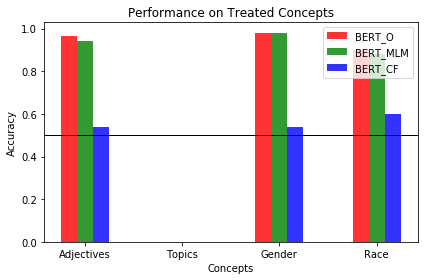

In [41]:
import matplotlib.pyplot as plt
output_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Figures/"

# data to plot
n_groups = 4
BERT_O = [0.964, 0, 0.98, 0.90]
BERT_MLM = [0.942, 0, 0.98, 0.88]
BERT_CF = [0.537, 0, 0.54, 0.60]
concepts = ('Adjectives', 'Topics', 'Gender', 'Race')

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.33
opacity = 0.8

rects1 = plt.bar(index - (bar_width/2), BERT_O, bar_width/2,
alpha=opacity,
color='r',
label='BERT_O')


rects2 = plt.bar(index, BERT_MLM, bar_width/2,
alpha=opacity,
color='g',
label='BERT_MLM')

rects3 = plt.bar(index + (bar_width/2), BERT_CF, bar_width/2,
alpha=opacity,
color='b',
label='BERT_CF')

plt.axhline(y=0.5,linewidth=1, color='k')

plt.xlabel('Concepts')
plt.ylabel('Accuracy')
plt.title('Performance on Treated Concepts')
plt.xticks(index, concepts)
plt.legend()
plt.tight_layout()
plt.savefig(output_dir + 'Performance_on_Treated_Concept.png', dpi=300)

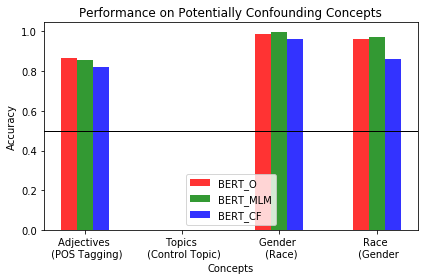

In [44]:
import matplotlib.pyplot as plt
output_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Figures/"

# data to plot
n_groups = 4
BERT_O = [0.864, 0, 0.985, 0.96]
BERT_MLM = [0.855, 0, 0.995,0.97]
BERT_CF = [0.822, 0, 0.96, 0.86]
concepts = ('Adjectives \n (POS Tagging)', 'Topics \n (Control Topic)', 'Gender \n (Race)', 'Race \n (Gender')

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.33
opacity = 0.8

rects1 = plt.bar(index - (bar_width/2), BERT_O, bar_width/2,
alpha=opacity,
color='r',
label='BERT_O')


rects2 = plt.bar(index, BERT_MLM, bar_width/2,
alpha=opacity,
color='g',
label='BERT_MLM')

rects3 = plt.bar(index + (bar_width/2), BERT_CF, bar_width/2,
alpha=opacity,
color='b',
label='BERT_CF')

plt.axhline(y=0.5,linewidth=1, color='k')

plt.xlabel('Concepts')
plt.ylabel('Accuracy')
plt.title('Performance on Potentially Confounding Concepts')
plt.xticks(index, concepts)
plt.legend()
plt.tight_layout()
plt.savefig(output_dir + 'Performance_on_Control_Concept.png', dpi=300)

In [92]:
experiments = ["/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched/COMPARE/lightning_logs/version_3",
               "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched_biased_joy_gentle/COMPARE/lightning_logs/version_5",
               "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched_biased_joy_aggressive/COMPARE/lightning_logs/version_2"
              ]




In [199]:

cur_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/gender_enriched_noisy_bias_gentle_3/COMPARE/lightning_logs/"
# df1 = pd.read_csv(cur_dir + "POMS_F_trained_F_gender_treated-test-predictions.csv")
df1 = pd.read_csv(cur_dir + "version_8/POMS_F_trained_F-test-predictions.csv")
df2 = pd.read_csv(cur_dir + "version_9/POMS_CF_trained_F_gender_treated-test-predictions.csv")
class_cols = [i for i in df1.columns if "class" in i]
CaCE_r = df1[class_cols].subtract(df2[class_cols]).abs().sum(axis=1).sum()/len(df1)


CaCE_r
# df1.correct.sum() / len(df1)
# df2.correct.sum() / len(df2)

0.5550104395072318

In [200]:
from sklearn.metrics import recall_score

recall = recall_score(df1['true'], df1['prediction'], average='macro')

recall

0.8829339715377668

In [256]:
cur_experiment = "gender_enriched_noisy"
cur_experiment = "gender_enriched_noisy_bias_gentle_3"
cur_experiment = "gender_enriched_noisy_bias_aggressive_3"
all_experiments_dir = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Experiments/POMS/"
all_test_data = "/home/amirf/GoogleDrive/AmirNadav/CausaLM/Data/POMS/Gender/Datasets/"
cur_experiment_dirs = os.listdir(os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/")
latest_version = str(sorted([int(i.split('_')[1]) for i in cur_experiment_dirs])[-2])
cur_experiment_preds = os.path.join(all_experiments_dir,cur_experiment) + "/COMPARE/lightning_logs/version_" + latest_version

df1 = pd.read_csv(cur_experiment_preds + "/POMS_F_trained_F-test-predictions.csv")
df1 = df1.set_index(["sample_index"])
df2 = pd.read_csv(cur_experiment_preds + "/POMS_CF_trained_F-test-predictions.csv")
df2 = df2.set_index(["sample_index"])
cur_test_data = os.path.join(all_test_data, cur_experiment + "_test.csv")
df_test_data = pd.read_csv(cur_test_data)
df_test_data = df_test_data.set_index(["ID_F"])

male_indices = df_test_data[df_test_data["Gender_F_label"] == 0].index.tolist()
female_indices = df_test_data[df_test_data["Gender_F_label"] == 1].index.tolist()

tpr_gap_1 = recall_score(df1.loc[male_indices]['true'], df1.loc[male_indices]['prediction'], average='weighted') - recall_score(df1.loc[female_indices]['true'], df1.loc[female_indices]['prediction'], average='weighted')
tpr_gap_2 = recall_score(df2.loc[male_indices]['true'], df2.loc[male_indices]['prediction'], average='weighted') - recall_score(df2.loc[female_indices]['true'], df2.loc[female_indices]['prediction'], average='weighted')


print(tpr_gap_1, tpr_gap_2)

-0.10702357023030473 0.10090665250336989
